Fetching all S&P 500 tickers...
Number of tickers: 501


C:\Users\bw391\AppData\Local\Temp\ipykernel_19628\2833918811.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_df = close_df.fillna(method='ffill').fillna(method='bfill')


Number of tickers with nearly full 3-year data: 501
Simulating 10,000 random portfolios...


Simulating portfolios: 100%|██████████| 10000/10000 [00:33<00:00, 295.79it/s]


Portfolio distribution statistics:
         Ann_Return  Ann_Volatility        Sharpe
count  10000.000000    10000.000000  10000.000000
mean       0.161096        0.181073      0.666794
std        0.057853        0.018283      0.301052
min       -0.045233        0.129722     -0.377783
25%        0.121733        0.168229      0.460396
50%        0.156146        0.179724      0.652342
75%        0.195229        0.191994      0.856042
max        0.545717        0.269158      2.079914
Plotting distributions and risk-return scatter...


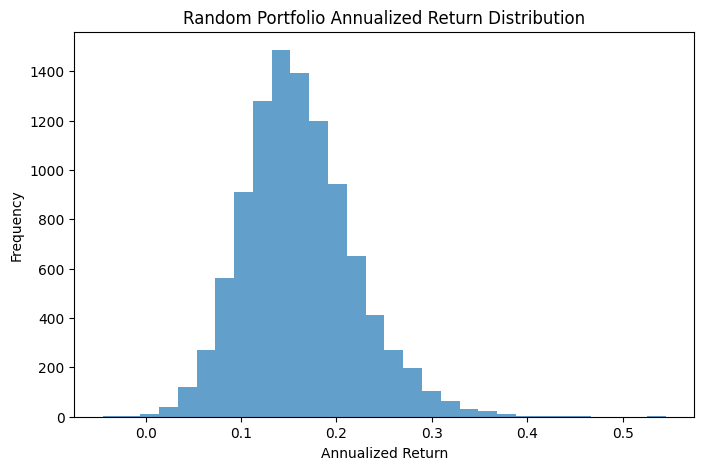

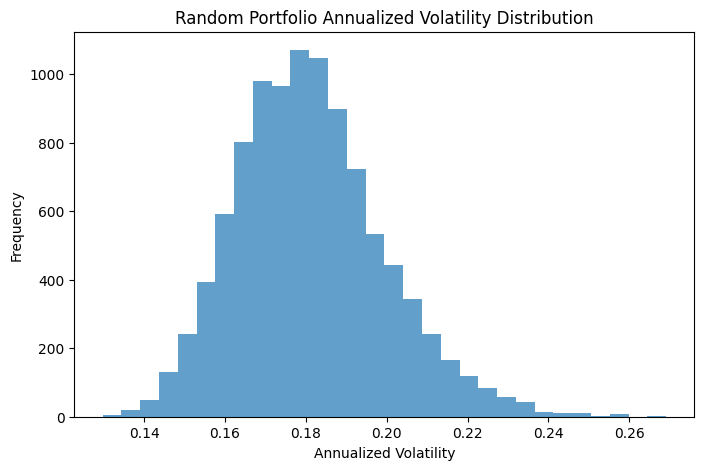

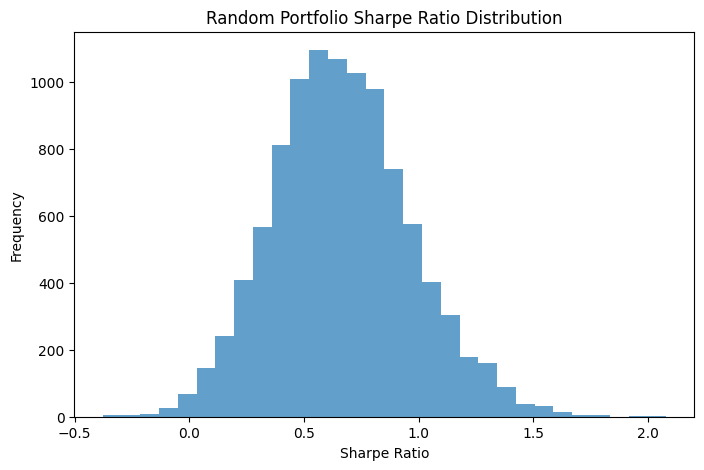

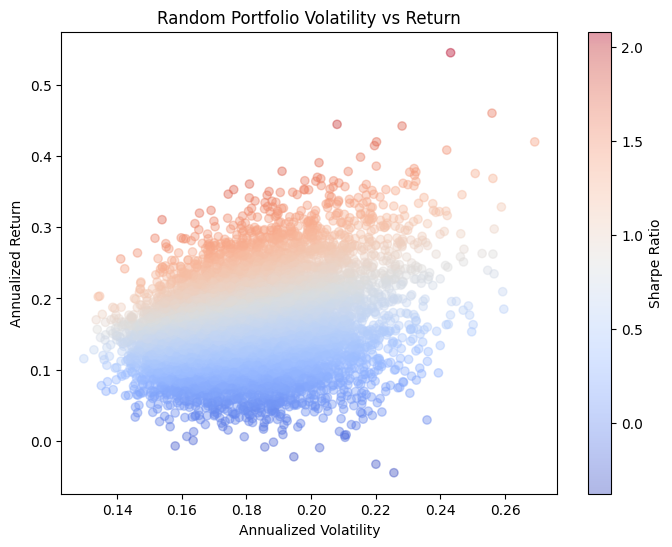

Extracting extreme high/low risk portfolios...
High risk portfolio:
Metrics: Ann_Return        0.420272
Ann_Volatility    0.269158
Sharpe            1.412822
Name: 7273, dtype: object
Tickers: ['MRK', 'PLTR', 'TSLA', 'CF', 'RCL', 'CPT', 'AXON', 'RVTY', 'AEE', 'CLX', 'COIN', 'DGX', 'TPR', 'ITW', 'JKHY', 'EW', 'NVDA', 'INTC', 'WTW', 'PODD']
Weights: [np.float64(0.014383529242302916), np.float64(0.01679813450143293), np.float64(0.11351015843674854), np.float64(0.0501243790084904), np.float64(0.022575327236896862), np.float64(0.028790338389456892), np.float64(0.11351015843674854), np.float64(0.11351015843674854), np.float64(0.011885347446576334), np.float64(0.010842555110475294), np.float64(0.09538382460511938), np.float64(0.04654054698315953), np.float64(0.0014837766904378623), np.float64(0.03179056275883363), np.float64(0.026553235779665077), np.float64(0.11351015843674854), np.float64(0.11351015843674854), np.float64(0.03231313726297827), np.float64(0.02578986959318275), np.float64(0.01

In [74]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500 = pd.read_html(url)[0]
    tickers = sp500['Symbol'].tolist()
    tickers.remove("BRK.B")
    tickers.remove("BF.B")
    return tickers

def get_price_data(tickers, years=3):
    end = datetime.today()
    start = end - timedelta(days=years*365)
    data = yf.download(
        tickers=" ".join(tickers),
        start=start.strftime('%Y-%m-%d'),
        end=end.strftime('%Y-%m-%d'),
        group_by='ticker',
        auto_adjust=True,
        threads=True,
        progress=False
    )
    close_df = pd.DataFrame({tic: data[tic]['Close'] for tic in tickers if tic in data.columns})

    # Fill missing values by forward/backward fill for small gaps (e.g. holidays, temporary suspensions)
    close_df = close_df.fillna(method='ffill').fillna(method='bfill')

    # Filter stocks that have data for almost all dates (allow at most 10 missing days)
    min_days = 252 * years - 10
    valid_tickers = [tic for tic in close_df.columns if close_df[tic].count() >= min_days]
    close_df = close_df[valid_tickers]

    # Only keep common trading days (not necessary to use dropna here to avoid data loss)
    # close_df = close_df.dropna()

    return close_df

def calc_portfolio_metrics(close_df, selected_tickers, weights, risk_free_rate=0.04):
    sub_prices = close_df[selected_tickers]
    returns = sub_prices.pct_change().dropna()
    port_returns = returns @ weights
    log_ret = np.log1p(port_returns)
    ann_ret = np.exp(log_ret.mean() * 252) - 1
    ann_vol = port_returns.std() * np.sqrt(252)
    sharpe = (ann_ret - risk_free_rate) / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

from tqdm import tqdm
def sample_weights(N, max_weight=0.1, max_trials=100):
    for _ in range(max_trials):
        w = np.random.dirichlet(np.ones(N), size=1)[0]
        if all(w <= max_weight):
            return w
    # fallback to clipping, then renormalize
    w = np.clip(w, None, max_weight)
    w = w / w.sum()
    return w

def random_portfolio_metrics(close_df, tickers, num_trials=10000, risk_free_rate=0.04):
    all_metrics = []
    N = 20
    for _ in tqdm(range(num_trials), desc="Simulating portfolios"):
        selected = random.sample(tickers, N)
        weights = sample_weights(N, max_weight=0.1)
        try:
            ann_ret, ann_vol, sharpe = calc_portfolio_metrics(close_df, selected, weights, risk_free_rate)
            all_metrics.append([
                ann_ret, ann_vol, sharpe,
                selected,
                list(weights)
            ])
        except Exception as e:
            continue
    return pd.DataFrame(
        all_metrics,
        columns=['Ann_Return','Ann_Volatility','Sharpe','Tickers','Weights']
    )

def plot_metrics(df, title_prefix="Random Portfolio"):
    plt.figure(figsize=(8,5))
    plt.hist(df['Ann_Return'], bins=30, alpha=0.7)
    plt.title(f'{title_prefix} Annualized Return Distribution')
    plt.xlabel('Annualized Return')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8,5))
    plt.hist(df['Ann_Volatility'], bins=30, alpha=0.7)
    plt.title(f'{title_prefix} Annualized Volatility Distribution')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8,5))
    plt.hist(df['Sharpe'], bins=30, alpha=0.7)
    plt.title(f'{title_prefix} Sharpe Ratio Distribution')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.show()

    # Risk-return scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(df['Ann_Volatility'], df['Ann_Return'], c=df['Sharpe'], cmap='coolwarm', alpha=0.4)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.title(f'{title_prefix} Volatility vs Return')
    plt.show()

def main():
    print("Fetching all S&P 500 tickers...")
    tickers = get_sp500_tickers()
    print("Number of tickers:", len(tickers))

    print("Downloading all price data...")
    close_df = get_price_data(tickers, years=3)

    print("Number of tickers with nearly full 3-year data:", len(close_df.columns))

    print("Simulating 10,000 random portfolios...")
    metrics_df = random_portfolio_metrics(close_df, list(close_df.columns), num_trials=10000)

    print("Portfolio distribution statistics:")
    print(metrics_df.describe())

    print("Plotting distributions and risk-return scatter...")
    plot_metrics(metrics_df, "Random Portfolio")

    # Next: get extreme high/low risk portfolios (directly select max/min, not from repeated random samples)
    print("Extracting extreme high/low risk portfolios...")
    high_idx = metrics_df['Ann_Volatility'].idxmax()
    low_idx = metrics_df['Ann_Volatility'].idxmin()

    print("High risk portfolio:")
    print("Metrics:", metrics_df.iloc[high_idx][['Ann_Return','Ann_Volatility','Sharpe']])
    print("Tickers:", metrics_df.iloc[high_idx]['Tickers'])
    print("Weights:", metrics_df.iloc[high_idx]['Weights'])

    print("Low risk portfolio:")
    print("Metrics:", metrics_df.iloc[low_idx][['Ann_Return','Ann_Volatility','Sharpe']])
    print("Tickers:", metrics_df.iloc[low_idx]['Tickers'])
    print("Weights:", metrics_df.iloc[low_idx]['Weights'])

if __name__ == '__main__':  
    main()
